# Exercise 2

## Physics 7810
## Due March 16, 2020

## E2.1 - Neighbor lists and cell lists

In this exercise you will implement the *neighbor list* and *cell list* methods for speeding up force/energy calculations in an MD simulation of the two-dimensional (2D) Weeks-Chandler-Andersen (WCA) model with periodic boundary conditions, and will compare the performance of these algorithms with an all-pairs ($O(N^2)$) neighbor search.

Recall that the WCA potential is just the Lennard-Jones potential truncated at the minimum ($r_c = 2^{1/6} \sigma$) and shifted so that the potential is continuous at the cutoff distance. In the WCA model, no long-range corrections to the potential energy or pressure (or other thermodynamic properties) are included.

(1) Write an MD simulation program for the 2D WCA model in a square box with periodic boundary conditions, using the velocity Verlet algorithm, and using an all-pairs search to compute pair interactions. Verify that the program works correctly, with stable dynamics (e.g., good energy conservation). Compare the average potential energy per particle and pressure measured in your simulation with the data in the file `WCA_thermodynamics_T_0.6.pdf` (from my PhD thesis!) in the Modules/Exercises folder in Canvas, which was obtained at a reduced temperature of $T^\ast = 0.6$. Try to reproduce the data on the low-density side of the melting transition ($\rho^\ast < 0.85$). To do this it's helpful to have a way to adjust the temperature of the system (e.g., a *thermostat*). I'd recommend using one of the simplest methods, involving periodic resampling of particle velocities (the *Andersen thermostat*), which is described in Section 3.8.1 in Allen & Tildesley.

(2) Implement the Verlet neighbor list method, with the neighbor list skin $\delta = r_l - r_c$ as an additional parameter that can be varied to optimize the performance of the algorithm. Note that the neighbor list cutoff $r_l$ cannot exceed half the linear dimension of the simulation box (i.e., you should make sure that $r_l \leq L/2$). The neighbor list for each particle can be implemented either as a simple array or as a linked list.

* Verify that using neighbor lists gives identical results to the all-pairs neighbor search, given the same initial conditions, at least for several hundred timesteps. If you see a significant discrepancy, this probably means that there's a mistake in your neighbor list implementation. Use the method discussed in class and in Allen & Tildesley (Section 5.3.1) to determine when to update the neighbor list.

* Measure the speedup of the neighbor list method relative to the all pairs method for various values of $\delta$ and $N$ (the number of particles). Hint: take a look at the `time` and `timeit` Python modules.

(3) Implement the cell search method, and repeat the steps outlined above for the neighbor list method. I'd recommend implementing the cell method using double-connected linked lists, as discussed in class and in Allen & Tildesley (Section 5.3.2). To acheive the best performance, you'll need to define `head` and `tail` arrays that contain the labels of the first and last particles in the linked list for each cell, `prev` and `next` arrays that contain the labels of the previous and next particles in the linked list that a given particle belongs to, and a `cell` array that specifies which cell a given particle is assigned to. Some care needs to be taken in handling periodic boundary conditions when using cell lists to calculate energies and forces.

## Solution

In this exercise, since the smallest system in `WCA_thermodynamics_T_0.6.pdf` still contains 896 particles, using all-pairs search method in Problem (1) would be too time-consuming, instead of using all-pairs method, we will first implement the Verlet list method and the cell list method, validate that they all produce the same results as the ones produced by the all-pairs method, and at last, use the fastest method to produce the result in `WCA_thermodynamics_T_0.6.pdf`. Here, we compare the total energy of the system at the last time frame of the simulation using different particle searching method to validate that they all generate the same results. In short, in the exercise, our goals include:
- Show that the Verlet method and the cell list method all generate the same results as the all-pairs search mehtod does and are always faster.
- Show that cell list method is faster than the Verlet method at larger $N$ (number of particles).
- Implementation of Andersen thermostat.
- Produce the results in `WCA_thermodyanmics_T_0.6.pdf`.

### Section 1. Physical validation of different particle searching methods

In this exercise, we developed `ParticleList` to implement both the Verlet list method and the cell list method. Specifically, the method `verlet_list` is for creating a neighbor list for each particle, which will be updated in Verlet integration whenever the displacement since the last update is larger than half of the neighbor list skin ($\delta$). On the other hand, `cell_list` method creates a cell list for each particle. It first utilizes `all_cells` to sort all the particles into different cells given the lenth of the cell ($r_{cell}$) using `find_cells` for each particle, then, given the coordinates of particles, it finds the cells that the particles belong to, identifies the neighboring cells using `neighbor_cells`, and finally, finds the indices of the particles in the search volume to loop over. In Verlet integration, instead of updating the cell list during every integration step, to decrease computational cost, we only update the cell list whenever a particle moves out from a cell and enter another.

As before, to begin with, we import the package `Molecular_Simulations`, read in the parameter file `Exercise_02.yml`, and instantiate the class and `Initialization` and `Molecular_Dynamics` to initialize the simulation. Here, our purpose is just to validates that the Verlet list method and the cell list method produce the same results as the all-pairs method does by comparing the total energy of the system at the last time step. Therefore, we adopt a small system of 50 particles and run 5000 steps in our MD simulation using the following parameters:
```yaml
# Simulation parameters
simulation: MD
N_particles: 50
N_steps: 5000
dt: 0.001
m: 1
r_c: 2.5 # the distance cutoff for the interaction potential (r_c = 0 : no truncation)
rho: 0.8
epsilon: 1  # epsilon in LJ potential
sigma: 1    # signma in LJ potential

dimension: 2
potential: 'WCA'
PBC: 'yes'
coords_method: 'lattice'  
velo_method: 'debug'
energy_truncation: 'yes'
shift_energy: 'yes'
tail_correction: 'no'

# thermostats and barostats
tcoupl: 'no'  # availale option: no (default), Andersen
mu: 50              # the collision rate of Andersen thermostat 
t_ref: 0.8          # can be used in NVT MC without barostats
nst_toupl: 10       # frequency to apply thermostat

# searching method
search_method: 'cell'
delta: 0.37753795      # the neighbor list skin, delta = r_v-r_c

# print options
print_freq: 10
print_param: 'no'
print_coords: 'yes'
print_Ek: 'yes'
print_Ep: 'yes'
print_Etotal: 'yes'
print_temp: 'no'
print_pressure: 'no'
print_L_total: 'no'
```

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [2]:
param = Initialization('Exercise_02.yml')
MD = MolecularDynamics(param)

In [3]:
MD.search_method = 'all-pairs'
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print('The total energy at the last time step calculated by the all-pairs method is: ', TA.E_total[-1])

MD.search_method = 'verlet'
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print('The total energy at the last time step calculated by the Verlet list method is: ', TA.E_total[-1])

MD.search_method = 'cell'
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print('The total energy at the last time step calculated by the cell list method is: ', TA.E_total[-1])

The total energy at the last time step calculated by the all-pairs method is:  169.81780612216994
The total energy at the last time step calculated by the Verlet list method is:  169.81780612216994
The total energy at the last time step calculated by the cell list method is:  169.8178061221699


As shown above, all methods produce exactly the same results. Therefore, when reproducing the results in `WCA_thermodyanmics_T_0.6.pdf` in Section 4, we will use the fastest method found in Section 2. (Note that from Section 1 to Section 3, the number density of the particles in the simulation will be maintained at 0.8. We will vary the density in Section 4.)

### Section 2. Comparison of the efficiency between different methods

#### Section 2-1. Comparison between the all-pairs method and the Verlet list method with different $\delta$ and $N$

To compare the efficiency of the all-pairs method and the Verlet list method with different $\delta$ and $N$, we develop `speedup_verlet_skin` and `compare_verlet_allpairs`. Specifically, we first fix the number of particles at 50 and use `speedup_verlet_skin` to find a neighbor skin that enables a better performance. Then, we use `compare_verlet_allpairs` to compare the efficiency between the two methods at various numbers of particles with the neighbor skin fixed the value we found by using `speedup_verlet_skin`. 

In [4]:
def compare_verlet_allpairs(param, N, delta):
    """
    This method plots the speedup by the Verlet list method as a function of 
    neighbor list skin at different number of particles.
    
    Parameters
    ----------
    param : obj
        An instance of class Initialization
    delta : list
        A list of neighbor list skin to examine.
    """
    speedup_data = []
    for i in range(len(N)):
        speedup_data.append([])
        param.N_particles = N[i]
        param.box_length = (N[i] / 0.8) ** (1 / param.dimension)
        MD = MolecularDynamics(param)
    
        t1 = time.time()
        MD.search_method = 'all-pairs'
        MD.verlet_integration(MD.velocities, MD.coords)
        t2 = time.time()
        dt1 = t2 - t1 
    
        for j in range(len(delta)):
            MD.delta = delta[j]

            t1 = time.time()
            MD.search_method = 'verlet'
            MD.verlet_integration(MD.velocities, MD.coords)
            t2 = time.time()
            speedup_data[i].append(dt1 / (t2 - t1))
        
    
    n_subplot = len(N)
    if int(np.sqrt(n_subplot) + 0.5) ** 2 == n_subplot:
        # perfect sqaure number
        n_cols = int(np.sqrt(n_subplot))
    else:
        n_cols = int(np.floor(np.sqrt(n_subplot))) + 1

    if n_subplot % n_cols == 0:
        n_rows = int(n_subplot / n_cols)
    else:
        n_rows = int(np.floor(n_subplot / n_cols)) + 1

    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    plt.suptitle('Speedup by the Verlet list method as a function of $\delta$ at different $N$')

    for i in range(n_subplot):
        plt.subplot(n_rows, n_cols, i + 1)
        data_range = max(speedup_data[i]) - min(speedup_data[i])
        plt.text(min(delta), 0.95 * data_range + min(speedup_data[i]), '($N$=%s)' % N[i])
        plt.plot(delta, speedup_data[i])
        if (i + 1) % n_cols == 1:
            plt.ylabel('Speedup factor')
        if (i + 1) > (n_rows - 1) * n_cols:
            plt.xlabel('Neighbor list skin ($\delta$)')
        plt.grid()
        
    # Remove redundant subplots
    n_rm = n_cols * n_rows - n_subplot
    for i in range(n_rm):
        ax.flat[-1 * (i + 1)].set_visible(False)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Time elapsed:  34008.57994842529


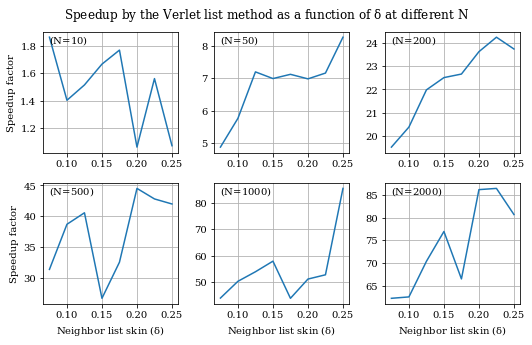

In [5]:
param = Initialization('Exercise_02.yml')
param.N_steps = 200
param.print_coords = 'no'
N = [10, 50, 200, 500, 1000, 2000]
delta = np.linspace(0.075, 0.25, 8)

t1 = time.time()
compare_verlet_allpairs(param, N, delta)
t2 = time.time()
print('Time elapsed: ', t2 - t1)

According to the result above, here are some observations:
- The Verlet list method is always more efficient that the all-pairs search method due to a smaller search volume.
- The speedup enabled by the Verlert list method relative to the all-pairs search method increases with the number of particles. This is because that the former has $\sim O(N^{3/2})$ computational cost, while the latter scales as  $\sim O(N^{2})$.
- The "optimal" neighbor list skin generally increases with the number of particles.
- For different number of particles, a neighbor list skin of 0.2 is generally good. Therefore, in Section 2-2., when comparing all the three methods, we will fix the value of neighbor list skin at this value and vary the number of particles. 

#### Section 2-2. Comparison between all the methods at different $N$

In this section, we fix the number density of the particles at 0.8 as before. In addition, we fix the value of neighbor list skin for the Verlet lsit method at 0.2, and fix the length of the cell at 1.234708 (which is about 1.1 times as large as the cutoff distance) for the cell list method. To compare all three kinds of method, we develop another function `compare_all` below, which generates a plot of simulation time as a function of the number of particles for each method. 

In [3]:
def compare_all(param, N):
    dt1, dt2, dt3 = [], [], []
    for i in range(len(N)):
        param.N_particles = N[i]
        param.box_length = (N[i] / 0.8) ** (1 / param.dimension)
        MD = MolecularDynamics(param)
        
        t1 = time.time()
        MD.search_method = 'all-pairs'
        MD.verlet_integration(MD.velocities, MD.coords)
        t2 = time.time()
        dt1.append(t2 - t1) 
        
        t1 = time.time()
        MD.delta = 0.25
        MD.search_method = 'verlet'
        MD.verlet_integration(MD.velocities, MD.coords)
        t2 = time.time()
        dt2.append(t2 - t1) 
        
        t1 = time.time()
        MD.r_cell = 1.234708
        MD.search_method = 'cell'
        MD.verlet_integration(MD.velocities, MD.coords)
        t2 = time.time()
        dt3.append(t2 - t1) 
        
    plt.figure()
    plt.plot(N, dt1, label='All-pairs method')
    plt.plot(N, dt2, label='Verlet list method')
    plt.plot(N, dt3, label='cell list method')
    plt.xlabel('Number of particles')
    plt.ylabel('Time elapsed (s)')
    plt.title('Comparison between the efficiency of different methods')
    plt.legend()
    plt.grid()

Time elapsed:  192598.4225962162


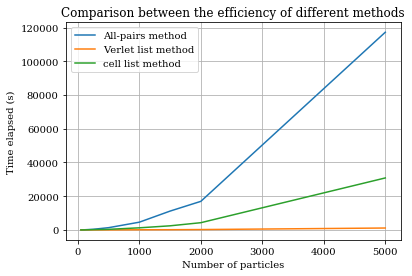

In [4]:
param = Initialization('Exercise_02.yml')
param.N_steps = 200
param.print_coords = 'no'
N = [50, 100, 250, 500, 1000, 1500, 2000, 5000]

t1 = time.time()
compare_all(param, N)
t2 = time.time()
print('Time elapsed: ', t2 - t1)

As shown above, the Verlet list method and the cell list method are apparently faster than the all-pairs method for different number of particles. For small number of particles, the Verlet list is faster than the cell list method due to a smaller search volume. However, for large $N$, the cell list method outperformed the Verlet list method. Note that the results in `WCA_thermodynamics_T_0.6.pdf` we want to reproduce in Section 4 are all from relatively large systems. To decrease the computational cost, in Section 4., we will only simulate a system of 200 particles. Accordingly, we will use the Verlet list method in the following section, since it is faster for a smaller $N$.

### Section 3. Implementation of Andersen thermostat

The simulations conducted in the previous sections were all in NVE ensembles. However, to reproduce the results in `WCA_thermodyanmics_T_0.6.pdf`, we have to run the simulation in an NVT ensemble instead, which requires a thermostat to maintain the temperature in the system. Accordingly, in this section, we implemented Andersen thermostat in the method for performing Verlet integration. We set the target temperature as 0.6, the collision rate of thermostat ($\nu$) as 50, and the frequency to apply thermostat as 10 steps. In addition, we initialize the particle velocities by drawing samples from Boltzmann-Maxwell distribution by specifying `velo_method = maxwell`. Whenever we apply the thermostat, we select $N\nu \Delta t$ particles at random to undergo a collision with the heat bath. Given $dt=0.001$, the probability of selecting a given particle during the time interval between the applications of thermostat (10 integration steps) is $10 \times 0.001 \nu = 0.5$. With the parameters specified, we run the simulation for 20000 steps to see
- if the pressure and the potential energy both equilibrate (so that we can reproduce the results in the next section)
- if the temperature of the system is around the target temperature (0.6) with a reasonable statistical uncertainty.

In the section, we use Verlet list method since it is the most efficient methods for this number of particles. According to Section 2, the "optimal" value of the neighbor list skin is about 0.175, so we will specify `delta` as this value in our simulation here.

In [11]:
param = Initialization('Exercise_02.yml')
param.N_steps = 100000
param.N_particles = 200
param.box_length = (param.N_particles / 0.8) ** (1 / param.dimension)
param.velo_method = 'maxwell'
param.temp = 0.6
param.search_method = 'verlet'
param.delta = 0.25

param.E_p = 'yes'
param.tcoupl = 'Andersen'
param.t_ref = 0.6
param.print_coords = 'no'
param.print_temp = 'yes'
param.print_pressure = 'yes'

MD = MolecularDynamics(param)
        
t1 = time.time()
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Time elapsed: ', t2 - t1)

Time elapsed:  6297.170292854309


After the simulation is complete, we can analyze the data as below.

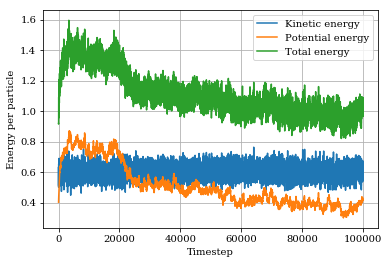

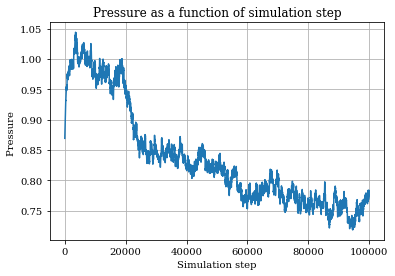

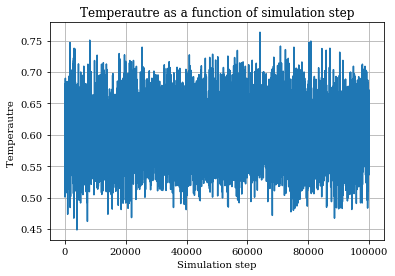

In [12]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
TA.plot_MD_energy()
TA.plot_2d(TA.pressure, 'Pressure')
TA.plot_2d(TA.temp, 'Temperautre')

As shown above, 

### Section 4. Reproduction of the results in `WCA_thermodynamics_T_0.6.pdf`

In this Exercise, we are asked to reproduce the results of the low density side ($\rho^{*} < 0.85$) of the melting transition in `WCA_thermodynamics_T_0.6.pdf`. Accordingly to the previous section, 20000 steps is sufficient to equilibrate the pressure and the potential energy of the system. Therefore, using Verlet list method ($\delta = 0.2$), here we run an MD simulation of 20000 steps for each value of density (from 0.8 to 0.85) as shown below.

In [7]:
def data_reproduction(param, rho):
    param.N_particles = 200
    param.N_steps = 20000
    param.velo_method = 'maxwell'
    param.temp = 0.6
    param.search_method = 'verlet'
    param.delta = 0.25 

    param.E_p = 'yes'
    param.tcoupl = 'Andersen'
    param.t_ref = 0.6
    param.print_coords = 'no'
    param.print_temp = 'yes'
    param.print_pressure = 'yes'
    
    pressure_avg, potntial_avg = [], []

    for i in range(len(rho)):
        param.rho = rho[i]
        # the box length will be calculated before the coordinates are initialized
        
        MD = MolecularDynamics(param)
        MD.verlet_integration(MD.velocities, MD.coords)
        TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
        pressure_avg.append(np.mean(TA.pressure[-200:]))  # average over last 2000 steps
        potential_avg.append(np.mean(TA.E_p[-200:]))  # average over last 2000 steps
    
    plt.figure()
    _, ax = plt.subplots(nrows=1, ncols=2)
    plt.suptitle('Reproduction of the results in WCA_thermodyanmics_T_0.6.pdf')
    
    plt.subplot(1, 2, 0)
    plt.plot(rho, pressure_avg)
    plt.xlabel('Density')
    plt.ylabel('Pressure')
    plt.grid()
    
    
    plt.subplot(1, 2, 1)
    plt.plot(rho, potential_avg)
    plt.xlabel('Density')
    plt.ylabel('Potential')
    plt.grid()        

In [8]:
param = Initialization('Exercise_02.yml')
rho = np.linspace(0.8, 0.85, 10)

t1 = time.time()
data_reproduction(param, rho)
t2 = time.time()
print('Time elapsed: ', t2 - t1)

ValueError: could not convert string to float: ' .nan\n'

As shown above,

In [3]:
%%prun -s cumulative -q -l 15 -T prun0
t1 = time.time()
MD.search_method = 'all-pairs'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 28.557636260986328
 
*** Profile printout saved to text file 'prun0'. 


10.805191097472726


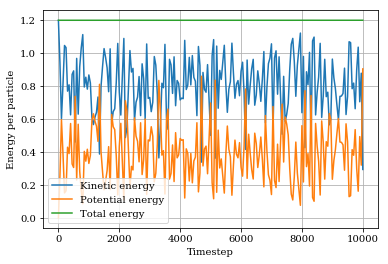

In [12]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print(TA.E_total[-1])
TA.plot_MD_energy()

In [13]:
print(open('prun0', 'r').read())

         19205126 function calls (19199096 primitive calls) in 25.063 seconds

   Ordered by: cumulative time
   List reduced from 128 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   25.063   25.063 {built-in method builtins.exec}
        1    0.000    0.000   25.063   25.063 <string>:2(<module>)
        1    0.201    0.201   25.062   25.062 Molecular_Simulations.py:719(verlet_integration)
    20000    2.030    0.000   17.133    0.001 Molecular_Simulations.py:318(total_force)
  1080036    4.945    0.000   15.344    0.000 Molecular_Simulations.py:252(calc_dist)
   720000    3.165    0.000   14.660    0.000 Molecular_Simulations.py:298(LJ_force_ij)
    10001    0.079    0.000    7.485    0.001 Molecular_Simulations.py:843(output_data)
    10001    0.635    0.000    7.322    0.001 Molecular_Simulations.py:484(total_potential)
  1090037    3.893    0.000    7.205    0.000 linalg.py:2293(norm)
   360036    

In [14]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'verlet'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 21.744179487228394
 
*** Profile printout saved to text file 'prun1'. 


10.805191097472726


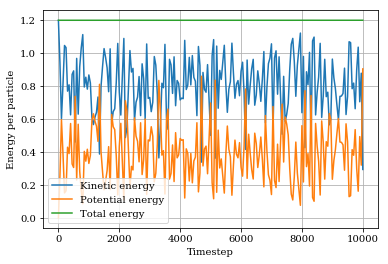

In [15]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
print(TA.E_total[-1])
TA.plot_MD_energy()

In [16]:
print(open('prun1', 'r').read())

         14660568 function calls (14654538 primitive calls) in 21.744 seconds

   Ordered by: cumulative time
   List reduced from 134 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   21.744   21.744 {built-in method builtins.exec}
        1    0.000    0.000   21.744   21.744 <string>:2(<module>)
        1    0.304    0.304   21.744   21.744 Molecular_Simulations.py:719(verlet_integration)
    20000    1.678    0.000   14.216    0.001 Molecular_Simulations.py:318(total_force)
   487846    3.192    0.000   12.040    0.000 Molecular_Simulations.py:298(LJ_force_ij)
   735642    3.778    0.000   11.613    0.000 Molecular_Simulations.py:252(calc_dist)
   835643    3.296    0.000    6.108    0.000 linalg.py:2293(norm)
    10001    0.092    0.000    6.096    0.001 Molecular_Simulations.py:843(output_data)
    10001    0.470    0.000    5.912    0.001 Molecular_Simulations.py:484(total_potential)
   243944    

0.17755071962448107

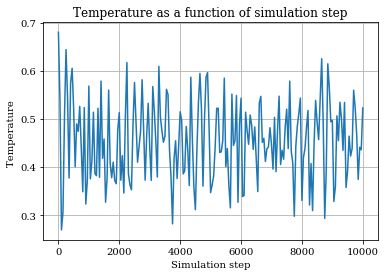

In [60]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
TA.plot_2d(TA.temp, 'Temperature')
TA.calculate_RMSF(TA.temp)

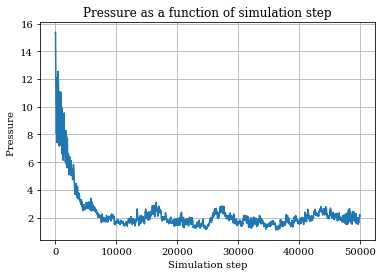

In [13]:
TA.plot_2d(TA.pressure, 'Pressure')

In [17]:
len(TA.pressure)

5001

In [19]:
np.mean(TA.pressure[4000:])

2.071241680753028

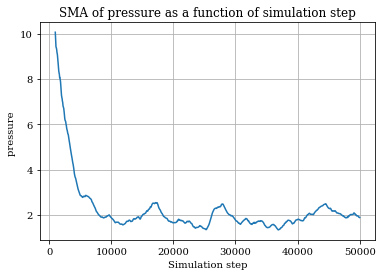

In [14]:
SMA = TA.plot_SMA(100, TA.pressure, 'pressure')

In [18]:
MD.coords

array([[-1.11803399, -1.11803399],
       [-1.11803399,  0.        ],
       [-1.11803399,  1.11803399],
       [ 0.        , -1.11803399],
       [ 0.        ,  0.        ],
       [ 0.        ,  1.11803399],
       [ 1.11803399, -1.11803399],
       [ 1.11803399,  0.        ],
       [ 1.11803399,  1.11803399]])

#### Problem 2: Application of Andersen thermostat the the reproduction of the `WCA_thermodynamics_T_0.6`

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [2]:
param = Initialization('Exercise_02.yml')
MD = MolecularDynamics(param)

In [3]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'cell'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 49.22199845314026
 
*** Profile printout saved to text file 'prun1'. 


5024.298670755838

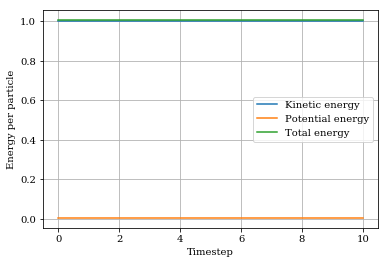

In [4]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
TA.plot_MD_energy()
TA.E_total[-1]

In [5]:
print(open('prun1', 'r').read())

         14935131 function calls (14934801 primitive calls) in 49.223 seconds

   Ordered by: cumulative time
   List reduced from 141 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   49.223   49.223 {built-in method builtins.exec}
        1    0.001    0.001   49.223   49.223 <string>:2(<module>)
        1    1.002    1.002   49.222   49.222 Molecular_Simulations.py:828(verlet_integration)
       20   25.170    1.258   38.614    1.931 Molecular_Simulations.py:323(total_force)
   782626    4.296    0.000   13.060    0.000 Molecular_Simulations.py:257(calc_dist)
   504920    3.273    0.000   12.233    0.000 Molecular_Simulations.py:303(LJ_force_ij)
       11    0.000    0.000    8.108    0.737 Molecular_Simulations.py:975(output_data)
       11    0.654    0.059    8.105    0.737 Molecular_Simulations.py:497(total_potential)
   277706    1.081    0.000    7.452    0.000 Molecular_Simulations.py:477(LJ_po

In [6]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'verlet'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 234.35983991622925
 
*** Profile printout saved to text file 'prun1'. 


5024.298670755838

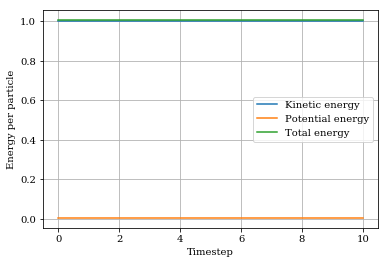

In [7]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
TA.plot_MD_energy()
TA.E_total[-1]

In [8]:
print(open('prun1', 'r').read())

         182215168 function calls (182214838 primitive calls) in 234.360 seconds

   Ordered by: cumulative time
   List reduced from 140 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  234.360  234.360 {built-in method builtins.exec}
        1    0.001    0.001  234.360  234.360 <string>:2(<module>)
        1    0.909    0.909  234.359  234.359 Molecular_Simulations.py:828(verlet_integration)
        1   15.084   15.084  198.650  198.650 Molecular_Simulations.py:581(verlet_list)
 12806198   61.877    0.000  188.340    0.000 Molecular_Simulations.py:257(calc_dist)
 12856209   46.630    0.000   87.021    0.000 linalg.py:2293(norm)
 13114906    5.194    0.000   41.409    0.000 fromnumeric.py:3373(round_)
 13114906    8.267    0.000   36.215    0.000 fromnumeric.py:2940(around)
       20   23.031    1.152   30.316    1.516 Molecular_Simulations.py:323(total_force)
 13114906    6.646    0.000   27.948    0.

In [11]:
%%prun -s cumulative -q -l 15 -T prun1
t1 = time.time()
MD.search_method = 'all-pairs'
MD.verlet_integration(MD.velocities, MD.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

Elapsed time: 30.123059511184692
 
*** Profile printout saved to text file 'prun1'. 


2015.7137759019759

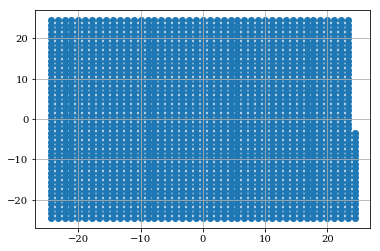

In [20]:
TA = TrajAnalysis(MD, 'Exercise_02_traj.yml')
#TA.plot_xy_traj()
plt.scatter(TA.x, TA.y)
plt.grid()
TA.E_total[-1]

In [1]:
import time
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

In [2]:
print(open('prun0', 'r').read())

         48048 function calls (47625 primitive calls) in 0.084 seconds

   Ordered by: cumulative time
   List reduced from 245 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.084    0.084 {built-in method builtins.exec}
        1    0.000    0.000    0.084    0.084 <string>:2(<module>)
        1    0.000    0.000    0.053    0.053 Molecular_Simulations.py:693(verlet_integration)
        1    0.000    0.000    0.040    0.040 Molecular_Simulations.py:786(output_data)
        1    0.011    0.011    0.040    0.040 Molecular_Simulations.py:390(virial)
        1    0.000    0.000    0.031    0.031 Molecular_Simulations.py:42(__init__)
     1560    0.009    0.000    0.027    0.000 Molecular_Simulations.py:244(calc_dist)
      780    0.003    0.000    0.022    0.000 Molecular_Simulations.py:290(LJ_force_ij)
        1    0.000    0.000    0.016    0.016 __init__.py:65(load)
        1    0.000    0.000    0.

#### Questinos to ask
- The mixing of Newtonian dynamics with stochastic collisions turns the Molecular Dynamics simulation into a Markov process. blablabla
- Draw from maxwell-Boltzmann: not rigorous enough?

In [5]:
A = MD.coords
B = MD.coords + 1

In [25]:
A

array([[-1.24404061,  1.08650181],
       [ 0.85392235, -0.37264796],
       [ 1.05170761,  0.18589252],
       ...,
       [-0.4253722 ,  0.46688536],
       [ 1.19515935,  1.02695679],
       [-0.76023485, -1.27546294]])

In [19]:
a = [C[i][0] ** 2 + C[i][1] ** 2 for i in range(len(C))]

In [28]:
t1 = time.time()
for i in range(10000):
    a = [norm(A[i]-B[i]) for i in range(len(C))]
t2 = time.time()
t2 - t1

33.216803312301636

In [30]:
t1 = time.time()
C = B - A
for i in range(10000):
    a = [norm(C[i]) for i in range(len(C))]
t2 = time.time()
t2 - t1

28.496031999588013

In [31]:
a

[1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4